SIMULATING REALTIME BY USING VAL,TESTING,TRAINING



Creating a csv file for all columns and shuffling?
send it to fleskine
split it to test train val
create a json file using val
Train model using train and test
Combine everything in a new notebook

# LIBRARIES


In [3]:
import pandas as pd
import numpy as np


In [4]:
training = pd.read_csv('Dataa/UNSW_NB15_training-set (1).csv')
testing = pd.read_csv('Dataa/UNSW_NB15_testing-set (1).csv')

print("training ",training.shape)
print("testing ",testing.shape)

training  (82332, 45)
testing  (175341, 45)


In [5]:
df = pd.concat([training,testing]).drop('id',axis=1)
df = df.reset_index(drop=True)

df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
## converting object/categorical data to numbers

for col in ['proto', 'service', 'state']:
      df[col] = df[col].astype('category').cat.codes
##.cat.codes attribute to replace the categorical values with numerical codes.

df['attack_cat'] = df['attack_cat'].astype('category') ##retains as cat

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['attack_cat', 'label']) ##all columns except 42 and 43 since were predicting the type of attack
y = df['label'].values ## predict whether it is 0 or 1  label column into a numpy array by values cause
#. A numpy array is more efficient and compatible for numerical computations than a pandas series

# Split the data into training and temporary sets so the training gets 20% and temp 80%

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and training sets
#(temp =80%) 80=100% so what about 25% is 20  for val and 60 for training
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [8]:
##only took the x column without the labels for simulating traffic

X_val.to_json("validation.json", orient='records', lines=True)


"validation.json": This is the name of the file where the JSON object will be stored. In this case, the file will be named “validation.json”.

orient='records': This parameter defines the format of the resulting JSON. When set to ‘records’, the JSON will be formatted as a list of records (dictionaries). Each record corresponds to a row in your DataFrame, with keys being column names and values being cell values.

lines=True: When set to True, this parameter writes each record (dictionary) on its own line in the file. This can make it easier to read the file and can be useful when working with large datasets, as it allows for reading in the file line by line.

attack_cat
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Normal                0
Name: count, dtype: int64


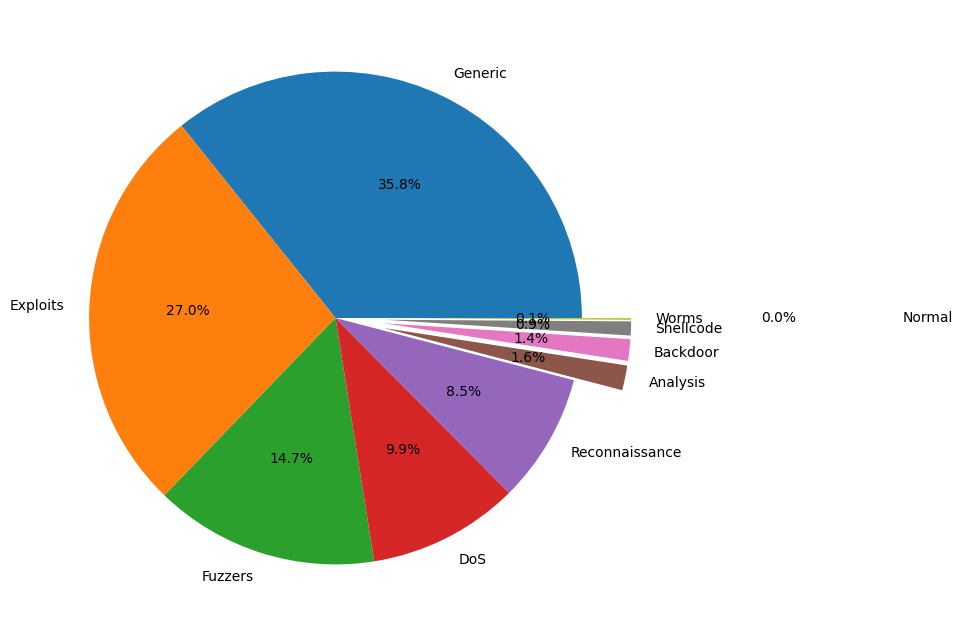

In [9]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
# import matplotlib as plt
# print(matplotlib.get_data_path())


validAttacks = df[df['label']==1]['attack_cat'].value_counts()
print(validAttacks)

#The subset is obtained by selecting the rows where the column label is equal to 1, and then selecting the column attack_cat. The value_counts() method returns a series that contains the frequency of each unique value in the column.

plt.figure(figsize = (15,8))
plt.pie(validAttacks,labels = validAttacks.index, autopct = '%1.1f%%',explode = [0,0,0,0,0,0.2,0.2,0.2,0.2,1.2])
plt.show()

# MODELS


## rf model with best esitamtors for recall


In [10]:
# Import the necessary modules
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Define the estimator
rf = RandomForestClassifier(random_state=11)

# Define the parameter grid
param_grid = {
    'n_estimators': [10],
    'max_depth': [5],
    'criterion': ['gini'],
    'class_weight': [None, 'balanced']
}

# Define the scoring function
scoring = 'recall'

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the test data
y_pred = grid_search.predict(X_test)

# Evaluate the recall on the test data
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

# Calculate and print the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("F1-score: ", f1)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 10}
Best score:  0.9918001775661901
Recall:  0.9962264150943396
Accuracy:  0.896963228873581
Precision:  0.8632456094087865
F1-score:  0.9249809273544123


In [11]:
rf_best = grid_search.best_estimator_
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':rf_best.feature_importances_})

#The importance score is a measure of how much a feature contributes to the prediction of the target variable. The code then sorts the DataFrame by the importance score in descending order and resets the index. 

feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)

feature_imp[:10].style.background_gradient()

,Name,Importance
0,dload,0.152480
1,ct_state_ttl,0.116127
2,rate,0.094394
3,sttl,0.090671
4,tcprtt,0.070409
5,sload,0.067696
6,state,0.045079
7,ackdat,0.043856
8,dinpkt,0.038392
9,dbytes,0.036910


In [12]:
top10= feature_imp.values[:10].tolist()
top10

[['dload', 0.15247977384245912],
 ['ct_state_ttl', 0.11612746233167999],
 ['rate', 0.09439370286704302],
 ['sttl', 0.09067090600233133],
 ['tcprtt', 0.07040944111095637],
 ['sload', 0.06769551730769295],
 ['state', 0.04507919760208618],
 ['ackdat', 0.04385622204806171],
 ['dinpkt', 0.038391608160083364],
 ['dbytes', 0.03690962565681942]]

## rf model with top 10 features for rf in maximizing recall

Accuracy:  0.8001733460971255
                precision    recall  f1-score   support

      Analysis       0.87      0.09      0.16       768
      Backdoor       0.64      0.04      0.08       658
           DoS       0.45      0.07      0.13      4909
      Exploits       0.60      0.88      0.71     13403
       Fuzzers       0.61      0.47      0.53      7283
       Generic       1.00      0.98      0.99     17790
        Normal       0.86      0.92      0.89     27814
Reconnaissance       0.84      0.71      0.77      4198
     Shellcode       0.42      0.26      0.32       418
         Worms       0.71      0.16      0.27        61

      accuracy                           0.80     77302
     macro avg       0.70      0.46      0.48     77302
  weighted avg       0.79      0.80      0.78     77302



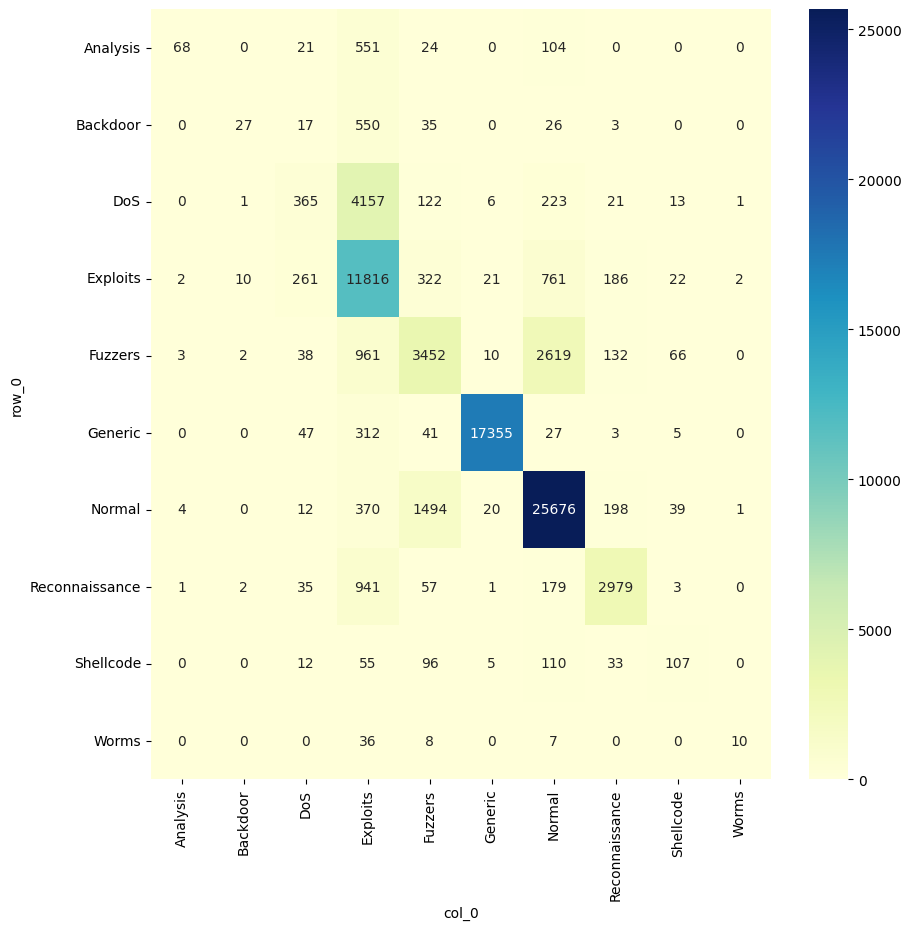

In [13]:
from sklearn.metrics import classification_report
import seaborn as sns

top10= feature_imp.Name[:10].tolist()

X = df.loc[:, df.columns.isin(top10)]

y = df['attack_cat'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

rf = RandomForestClassifier(random_state=11,min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

report = classification_report(y_test, y_pred)
print(report)
### NOTESS WHAT EACH NUMBER MEANS IN THE TABLEE (TO DOOO)
cross = pd.crosstab(y_test,  y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
plt.show()

In [14]:
X_train

,state,dbytes,rate,sttl,sload,dload,dinpkt,tcprtt,ackdat,ct_state_ttl
245267,5,0,3.333333e+05,254,1.520000e+08,0.000000e+00,0.000000,0.000000,0.000000,2
90663,2,304,5.682279e+01,31,2.766458e+04,1.480640e+04,23.610000,0.000000,0.000000,0
124782,4,354,2.921730e+01,254,1.995026e+04,4.262289e+03,76.586000,0.103179,0.057439,1
210530,5,0,1.000000e+06,254,4.560000e+08,0.000000e+00,0.000000,0.000000,0.000000,2
71089,4,682,3.508643e+01,254,7.078307e+03,7.639689e+03,55.460910,0.086544,0.041794,1
...,...,...,...,...,...,...,...,...,...,...
97617,4,54798,2.750005e+03,31,6.390245e+05,9.203863e+06,0.723297,0.000734,0.000124,0
203867,4,768,1.702715e+01,254,3.375159e+03,3.602188e+03,116.003766,0.164652,0.086999,1
21584,5,0,3.333333e+05,254,1.520000e+08,0.000000e+00,0.000000,0.000000,0.000000,2
36543,4,71834,4.496506e+03,31,1.029213e+06,1.625318e+07,0.434291,0.000721,0.000124,0


### Saving model instance

In [15]:
# import joblib

# # Save the model as a pickle file
# joblib.dump(rf, 'rf_model.pkl')


['rf_model.pkl']

# picking up traffic and passing to the model



In [16]:
import json
import pandas as pd
import random
import time
import streamlit as st


# Specify the path to your JSON file
json_file_path = 'validation.json'  # replace with the path to your JSON file

data = []

with open(json_file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))


# Select the 10 features
# features = ['dload', 'ct_state_ttl', 'rate', 'sttl', 'tcprtt', 'sload', 'state', 'ackdat', 'dinpkt', 'dbytes']
features = ['state', 'dbytes', 'rate', 'sttl', 'sload', 'dload', 'dinpkt', 'tcprtt', 'ackdat', 'ct_state_ttl']


# # STOPS MANUALLY
# while True:
#     # Select a random packet
#     packet = random.choice(data)

#     # Select the 10 features from the packet
#     selected_data = {feature: packet[feature] for feature in features}

#     # Convert to DataFrame as the model expects input in this format
#     df = pd.DataFrame([selected_data] , columns=features)

#     df

#     # Use the trained model to make predictions
#     predictions = rf.predict(df)

#     print(selected_data, ':', predictions)


#     # Wait for 5 seconds before selecting the next packet
#     time.sleep(5)









## FOR LOOP TO STOP AFTER 10 PACKETS ARE PICKED


num_iterations = 10  # replace with the number of iterations you want

for _ in range(num_iterations):
    # Select a random packet
    packet = random.choice(data)

    # Select the 10 features from the packet
    selected_data = {feature: packet[feature] for feature in features}

    # Convert to DataFrame as the model expects input in this format
    df = pd.DataFrame([selected_data], columns=features)

    # Use the trained model to make predictions
    predictions = rf.predict(df)

    # # Display the DataFrame as a table in Streamlit
    # st.table(df)

    print(selected_data, ':', predictions)

    # Wait for 5 seconds before selecting the next packet
    time.sleep(5)



{'state': 4, 'dbytes': 63516, 'rate': 1508.719404, 'sttl': 31, 'sload': 347941.9063, 'dload': 5215632.5, 'dinpkt': 1.308069, 'tcprtt': 0.000731, 'ackdat': 0.00012, 'ct_state_ttl': 0} : ['Normal']
{'state': 4, 'dbytes': 268, 'rate': 20.029243, 'sttl': 254, 'sload': 5138.168457, 'dload': 2392.826904, 'dinpkt': 127.455602, 'tcprtt': 0.210732, 'ackdat': 0.099111, 'ct_state_ttl': 1} : ['Normal']
{'state': 4, 'dbytes': 268, 'rate': 29.238227, 'sttl': 254, 'sload': 8233.484375, 'dload': 3492.993408, 'dinpkt': 82.562602, 'tcprtt': 0.169124, 'ackdat': 0.068916, 'ct_state_ttl': 1} : ['Fuzzers']
{'state': 4, 'dbytes': 16290, 'rate': 7304.382486, 'sttl': 31, 'sload': 1817090.25, 'dload': 12697218.0, 'dinpkt': 0.253865, 'tcprtt': 0.000778, 'ackdat': 0.000181, 'ct_state_ttl': 0} : ['Normal']
{'state': 5, 'dbytes': 0, 'rate': 1.32821, 'sttl': 254, 'sload': 2890.185547, 'dload': 0.0, 'dinpkt': 0.0, 'tcprtt': 0.0, 'ackdat': 0.0, 'ct_state_ttl': 2} : ['Exploits']
{'state': 5, 'dbytes': 0, 'rate': 200000

In [24]:
df

,state,dbytes,rate,sttl,sload,dload,dinpkt,tcprtt,ackdat,ct_state_ttl
0,5,0,125000.000300,254,1.000000e+08,0.000000,0.000000,0.000000,0.000000,2
1,5,0,111111.107200,254,8.888889e+07,0.000000,0.000000,0.000000,0.000000,2
2,5,0,200000.005100,254,1.600000e+08,0.000000,0.000000,0.000000,0.000000,2
3,4,354,12.463791,254,2.979579e+03,1818.247192,181.042719,0.198062,0.101419,1
4,5,0,111111.107200,254,5.066666e+07,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...
51530,5,0,166666.660800,254,7.600000e+07,0.000000,0.000000,0.000000,0.000000,2
51531,4,6922,45.661651,62,9.310040e+03,64923.460940,41.134264,0.067397,0.045810,1
51532,5,0,125000.000300,254,5.700000e+07,0.000000,0.000000,0.000000,0.000000,2
51533,4,3814,59.546758,62,1.955641e+04,86073.273440,31.665667,0.086048,0.052731,1


# STREAMLIT WEB APP 


In [26]:
import streamlit as st
import pandas as pd
import time
import json
# from sklearn.externals import joblib

# Load your model
model = rf


# data = []

# with open('validation.json', 'r') as f:
#     for line in f:
#         data.append(json.loads(line))

# # # Load the json file
# # with open('validation.json') as f:
# #     data = json.load(f)

# # Convert to DataFrame
# df = pd.DataFrame(data)

# Select the top 10 features
# features = ['dload',
#  'ct_state_ttl',
#  'rate',
#  'sttl',
#  'tcprtt',
#  'sload',
#  'state',
#  'ackdat',
#  'dinpkt',
#  'dbytes']
#features = ['state', 'dbytes', 'rate', 'sttl', 'sload', 'dload', 'dinpkt', 'tcprtt', 'ackdat', 'ct_state_ttl']





def simulate_traffic(df):
    for i in range(0, len(df)):
        # Select the packet
        packet = df.iloc[i:i+1]
        
        # Predict the label
        label = model.predict(packet)
        
        # Add the label to the packet
        #packet['label'] = label
        
        #yield packet
        print(label)

# Streamlit app
st.title('Network Traffic Simulation')

# Create a placeholder for the table
table_placeholder = st.empty()

# Simulate network traffic and display packets in the table
for packet in simulate_traffic(df):
    # Display the packet in the table
    table_placeholder.table(packet)
    
    # Wait for 5 seconds before processing the next packet
    time.sleep(5)


['Exploits']
['Exploits']
['Exploits']
['Reconnaissance']
['Generic']
['Exploits']
['Generic']
['Normal']
['Normal']
['Normal']
['Exploits']
['Normal']
['Exploits']
['Normal']
['DoS']
['Generic']
['Normal']
['Fuzzers']
['Normal']
['Normal']
['Generic']
['Normal']
['Normal']
['Fuzzers']
['Generic']
['Generic']
['Generic']
['Normal']
['Normal']
['Generic']
['Fuzzers']
['Normal']
['Normal']
['Normal']
['Generic']
['Normal']
['Generic']
['Reconnaissance']
['Exploits']
['Normal']
['Normal']
['Exploits']
['Exploits']
['Normal']
['Generic']
['Normal']
['Generic']
['Generic']
['Generic']
['Fuzzers']
['Fuzzers']
['Normal']
['Normal']
['Exploits']
['Generic']
['Exploits']
['Shellcode']
['Exploits']
['Generic']
['Exploits']
['Exploits']
['Exploits']
['Normal']
['Normal']
['Normal']
['Normal']
['Generic']
['Fuzzers']
['Exploits']
['Generic']
['Exploits']
['Fuzzers']
['Generic']
['Generic']
['Normal']
['Fuzzers']
['Fuzzers']
['Normal']
['Normal']
['Normal']
['Normal']
['Reconnaissance']
['Exploits'

KeyboardInterrupt: 

In [ ]:
# # Import necessary libraries
# import streamlit as st
# import pandas as pd
# import time
# import json
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

# # Assuming rf is your trained model
# model = rf

# # Initialize an empty list to store the data from the JSON file
# data = []

# # Open the JSON file and load each line as a separate JSON object
# with open('validation.json', 'r') as f:
#     for line in f:
#         data.append(json.loads(line))

# # Convert the list of JSON objects into a DataFrame
# df = pd.DataFrame(data)

# # Specify the features that your model was trained on
# features = ['dload', 'ct_state_ttl', 'rate', 'sttl', 'tcprtt', 'sload', 'state', 'ackdat', 'dinpkt', 'dbytes']

# # Create a ColumnTransformer that selects only these features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('select', 'passthrough', features)
#     ])

# # Create a Pipeline that uses the preprocessor and then your model
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', rf)  # Assuming rf is your trained model
# ])

# # Define a function to simulate network traffic
# def simulate_traffic(df):
#     # Loop through each row (packet) in the DataFrame
#     for i in range(0, len(df)):
#         # Select the packet
#         packet = df.iloc[i:i+1]
        
#         # Use your model to predict the label for this packet
#         label = model.predict(packet)
        
#         # Add the predicted label to the packet
#         packet['label'] = label
        
#         # Yield the packet, making this function a generator
#         yield packet

# # Start of Streamlit app
# st.title('Network Traffic Simulation')

# # Create a placeholder where the table will be displayed
# table_placeholder = st.empty()

# # Simulate network traffic and display packets in the table
# for packet in simulate_traffic(df):
#     # Display the packet in the table placeholder
#     table_placeholder.table(packet)
    
#     # Pause for 5 seconds before processing the next packet, simulating real-time traffic
#     time.sleep(5)
